# deprecated

In [48]:
import os
import subprocess
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import dynamo as dyn
import matplotlib.pyplot as plt

In [128]:
wangxiao_g1s = ['BCL2L1', 'CDC6', 'DSCC1', 'DTL', 'MCM5', 'UNG', 'SNN', 'FEN1',
                'GINS2', 'GMNN', 'MCM2', 'MCM4', 'MCM6', 'PCNA', 'PRIM1', 'RRM1', 'TYMS', 'UHRF1',
                'CDCA7']
wangxiao_g2m = ['TOP2A', 'TPX2', 'UBE2C', 'HJURP', 'BIRC5', 'CCNB2', 'CDCA2',
                'CKAP5', 'CKS1B', 'CKS2', 'HMGB2', 'NCAPD2', 'NDC80', 'NUF2', 'TACC3', 'TMPO',
                'MKI67', 'CENPF']
science_g1s = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL',
               'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP',
               'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN',
               'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
science_g2m = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67',
               'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E',
               'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1',
               'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5',
               'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']

def change(genes):
    for g in genes:
        yield g[0].upper() + g[1:].lower()

strain = "K562"

if strain == "K562":
    anno_g = pd.read_csv("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/gencode.v39.annotation.tsv", sep="\t")
    s4u = 50
    min_tc_ratio = 0.008
elif strain == "mESC":
    anno_g = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.annotation.tsv", sep="\t")
    s4u = 400
    min_tc_ratio = 0.01
    wangxiao_g1s = list(change(wangxiao_g1s))
    wangxiao_g2m = list(change(wangxiao_g2m))
    science_g1s = list(change(science_g1s))
    science_g2m = list(change(science_g2m))
else:
    assert False
    
s_genes, g2m_genes = science_g1s, science_g2m
#s_genes, g2m_genes = wangxiao_g1s, wangxiao_g2m
print(len(s_genes), len(g2m_genes))

gid2gtype = dict()
gid2gname = dict()
for gid, gtype, gname in anno_g[["GeneID", "GeneType", "GeneName"]].values:
    gid2gtype[gid] = gtype
    gid2gname[gid] = gname
    
d = pd.read_excel("../../1_NanoNASCseq/data/NanoNASCseq_summary_selected.xls")
d = d[(d["Strain"] == strain) & (d["s4U"] == s4u) & (d["Time"] == 3) & (d["ActD"].isna()) & (d["UMIs"] >= 5000) & (d["TCRatio"] > min_tc_ratio)]
len(d)

43 54


105

In [129]:
outfile1 = "results/%s_%duM_3h_counts.genes.filelist.txt" % (strain, s4u)
outfile2 = "results/%s_%duM_3h_counts.genes.gene_id.total.tsv" % (strain, s4u)
outfile3 = "results/%s_%duM_3h_counts.genes.gene_id.nascent.tsv" % (strain, s4u)
outfile4 = "results/%s_%duM_3h_counts.genes.gene_id.meta.tsv" % (strain, s4u)
outfile5 = "results/%s_%duM_3h_counts.genes.gene_name.total.tsv" % (strain, s4u)
outfile6 = "results/%s_%duM_3h_counts.genes.gene_name.nascent.tsv" % (strain, s4u)
outfile7 = "results/%s_%duM_3h_counts.genes.gene_name.meta.tsv" % (strain, s4u)

if not os.path.exists(outfile2):
    with open(outfile1, "w+") as fw:
        for run, cell in d[["Run", "Cell"]].values:
            path = "../../1_NanoNASCseq/results/expression/quant_genes/min_read_2_min_tc_2/%s/%s.tsv" % (run, cell)
            fw.write(path + "\n")
    cmd = "../../1_NanoNASCseq/scripts/make_count_matrix.py %s %s %s" % (outfile1, outfile2, outfile3)
    subprocess.check_call(cmd, shell=True)
    d.to_csv(outfile4, sep="\t", index=False)
    os.remove(outfile1)

if not os.path.exists(outfile5):
    m = pd.read_csv(outfile2, sep="\t", header=0, index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile5, sep="\t")

    m = pd.read_csv(outfile3, sep="\t", header=0, index_col=0)
    m.index = [gid2gname.get(x, x) for x in m.index]
    m.index.name = "GeneName"
    m = m[~m.index.duplicated()]
    m.to_csv(outfile6, sep="\t")

    d.to_csv(outfile7, sep="\t", index=False)

In [130]:
matrix = pd.read_csv("results/%s_%duM_3h_counts.genes.gene_name.total.tsv" % (strain, s4u), sep="\t", header=0, index_col=0)
adata = anndata.AnnData(matrix.T)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
s_genes = list(filter(lambda x: x in adata.var_names, s_genes))
g2m_genes = list(filter(lambda x: x in adata.var_names, g2m_genes))
cell_cycle_genes = s_genes + g2m_genes
print(len(s_genes), len(g2m_genes))
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
print(Counter(adata.obs["phase"]))
x = adata.obs["phase"]
cell2phase = {cell: phase for cell, phase in zip(x.index, x.values)}

42 50
Counter({'S': 42, 'G1': 32, 'G2M': 31})


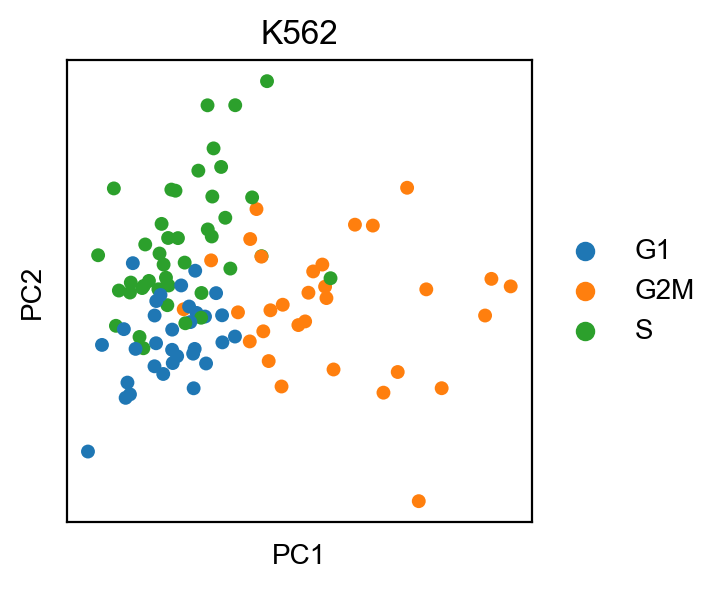

<Figure size 640x480 with 0 Axes>

In [131]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
plt.figure(figsize=(3, 3))
sc.pl.pca_scatter(adata_cc_genes, color='phase', ax=plt.gca(), size=100, title=strain)
plt.tight_layout()
plt.show()
plt.close()

In [117]:
mtx1 = pd.read_csv("results/%s_%duM_3h_counts.genes.gene_name.total.tsv" % (strain, s4u), sep="\t", header=0, index_col=0)
mtx2 = pd.read_csv("results/%s_%duM_3h_counts.genes.gene_name.nascent.tsv" % (strain, s4u), sep="\t", header=0, index_col=0)
phases = ["G1", "S", "G2M"]
array = []
for phase in phases:
    tmp = adata.obs
    cells = tmp[tmp["phase"] == phase].index
    s1 = mtx1[cells].sum(axis=1)
    s2 = mtx2[cells].sum(axis=1)
    s1.name = "Total"
    s2.name = "Nascent"
    m = pd.concat([s1, s2], axis=1)
    m["NTR"] = m["Nascent"] / m["Total"]
    m["TPM"] = m["Total"] * 1e6 / m["Total"].sum()
    m["T"] = -3 / np.log2(1 - m["NTR"])
    m["D"] = np.log(2) / m["T"]
    m["K"] = m["TPM"] * m["D"]
    m.columns = ["%s.%s" % (c, phase) for c in m.columns]
    array.append(m)
    # break

/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Genes: 929
           K.G1       K.S     K.G2M      D.G1       D.S     D.G2M
K.G1   1.000000  0.931778  0.936918  0.321000  0.269774  0.276077
K.S    0.931778  1.000000  0.956973  0.186962  0.249863  0.220057
K.G2M  0.936918  0.956973  1.000000  0.205135  0.231712  0.261141
D.G1   0.321000  0.186962  0.205135  1.000000  0.862152  0.864257
D.S    0.269774  0.249863  0.231712  0.862152  1.000000  0.918617
D.G2M  0.276077  0.220057  0.261141  0.864257  0.918617  1.000000


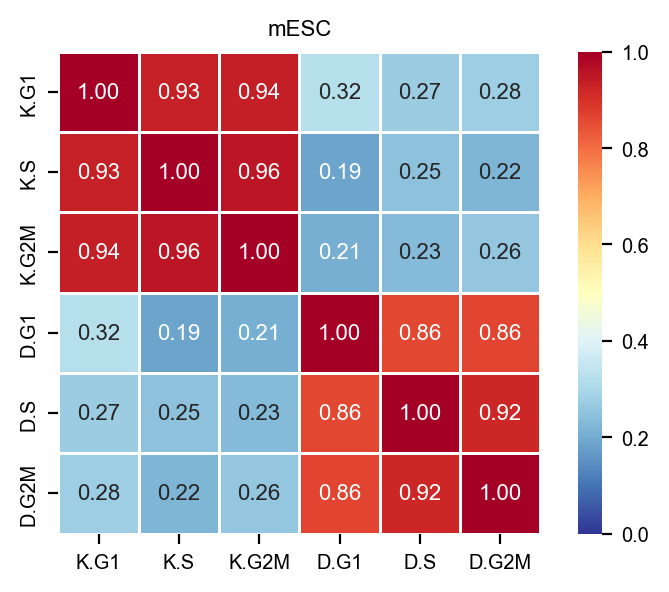

In [118]:
dat = pd.concat(array, axis=1)
for phase in phases:
    dat = dat[dat["Total.%s" % phase] > 20]
    # dat = dat[dat["TPM.%s" % phase] > 200]
    dat = dat[dat["Nascent.%s" % phase] > 0]
    dat = dat[dat["Total.%s" % phase] > dat["Nascent.%s" % phase]]
print("Genes:", len(dat))

d1 = dat[["K.%s" % phase for phase in phases] + ["D.%s" % phase for phase in phases]]
print(d1.corr())
plt.figure(figsize=(4, 3))
plt.title(strain)
sns.heatmap(d1.corr(), cmap="RdYlBu_r", annot=True, fmt=".2f", vmin=0, vmax=1, lw=1, square=True)
plt.tight_layout()

In [120]:
adata = anndata.AnnData(mtx1.T)
adata.layers["total"] = mtx1.T
adata.layers["new"] = mtx2.T

In [121]:
adata.obs["phase"] = [cell2phase[cell] for cell in adata.obs.index]

In [122]:
adata.obs["time"] = 3

In [123]:
adata = adata[:, cell_cycle_genes]

In [124]:
dyn.pp.recipe_monocle(adata, tkey="time")

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> 
Dynamo detects your labelin

/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/preprocessing/utils.py:322: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  new_df = origin_df.merge(diff_df[_columns], how="left", left_index=True, right_index=True)
/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/preprocessing/cell_cycle.py:464: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  cell_cycle_scores["cell_cycle_phase"].cat.set_categories(phase_list, inplace=True)


|-----> [cell phase estimation] in progress: 100.0000%
|-----> [cell phase estimation] finished [5394.4320s]
|-----> <insert> cell_cycle_phase to obs in AnnData Object.
|-----> <insert> cell_cycle_scores to obsm in AnnData Object.
|-----> [Cell Cycle Scores Estimation] in progress: 100.0000%
|-----> [Cell Cycle Scores Estimation] finished [0.5810s]
|-----> [recipe_monocle preprocess] in progress: 100.0000%
|-----> [recipe_monocle preprocess] finished [0.6992s]


/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/preprocessing/cell_cycle.py:482: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cell_cycle_scores["cell_cycle_order"] = cell_cycle_scores.groupby("cell_cycle_phase")["cell_cycle_order"].apply(


In [125]:
dyn.tl.dynamics(adata, model='stochastic', cores=3, NTR_vel=True)
dyn.tl.reduceDimension(adata)
dyn.tl.leiden(adata)
dyn.tl.hdbscan(adata)
dyn.tl.louvain(adata)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [7.3672s]


/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/tools/utils.py:1117: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.var.loc[valid_ind, kin_param_pre + "gamma"] = gamma
/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/tools/utils.py:1118: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.var.loc[valid_ind, kin_param_pre + "half_life"] = None if gamma is None else np.log(2) / gamma
/home/chenzonggui/miniconda3/envs/scanpy/lib/python3.10/site-packages/dynamo/tools/utils.py:1184: FutureWarni

|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [7.3511s]
|-----> accessing adj_matrix_key=distances built from args for clustering...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> Detecting communities on graph...
Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'infomap', 'karateclub', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some a

In [126]:
dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
dyn.vf.VectorField(adata, basis='umap')

|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [0.1206s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.1071s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [0.1189s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.0993s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional gri

|-----------> plotting with basis key=X_umap
|-----------> skip filtering phase by stack threshold when stacking color because it is not a numeric type
|-----------> plotting with basis key=X_umap_rnd
|-----------> skip filtering phase by stack threshold when stacking color because it is not a numeric type


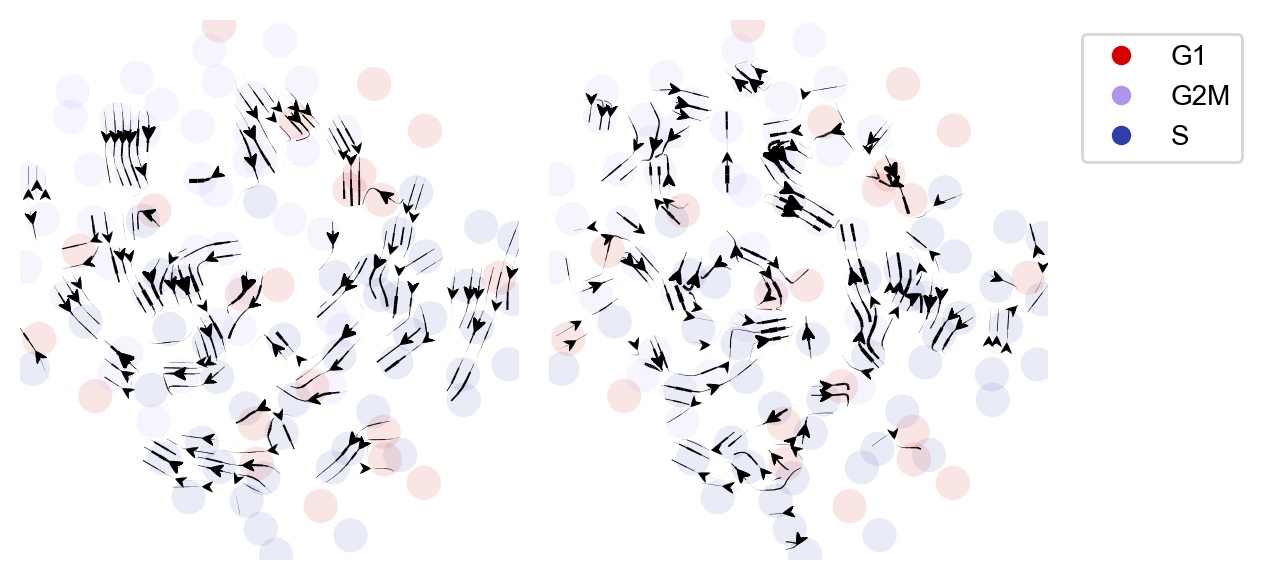

In [127]:
# color = "leiden"
color = "louvain"
color = "phase"
# color = "cell_cycle_phase"
pointsize = 0.1
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))
dyn.pl.streamline_plot(adata, 
                       color=color, 
                       pointsize=pointsize, 
                       #color_key=color_key,
                       basis='umap', ax=axs[0], show_legend=False, save_show_or_return='return')
dyn.pl.streamline_plot(adata, 
                       color=color, 
                       pointsize=pointsize,
                       #color_key=color_key,
                       basis='umap_rnd', ax=axs[1], show_legend='right', save_show_or_return='return')
for ax in axs:
    ax.set_title(None)
plt.tight_layout()
if True:
    plt.show()
else:
    plt.savefig("figures/rna_velocity.isoform_based.png", dpi=300)
plt.close()